<a href="https://colab.research.google.com/github/FaatihFath/Praktikum-Mandiri-ML/blob/main/Praktikum_Mandiri_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install folium

In [2]:
!pip install contextily

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
path="/content/drive/MyDrive/Praktikum Machine Learning/Praktikum 11"

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import plotly.express as px


Notes :

pandas (pd) Untuk membaca, mengelola, dan memproses data dalam bentuk tabel
(DataFrame).

seaborn (sns) Membuat visualisasi statistik seperti heatmap, regplot, dan grafik korelasi.

matplotlib.pyplot (plt) Visualisasi dasar (grafik batang, garis, dan peta).

numpy (np) Melakukan operasi numerik, perhitungan matematis, dan manipulasi
array.

folium Membuat peta interaktif berbasis Leaflet untuk menampilkan data spasial.

HeatMap (folium.plugins) Membuat peta sebaran panas (heatmap) dari titik koordinat.

geopandas (gpd) Mengelola data spasial (geometri) seperti titik, garis, dan poligon.

contextily (ctx) Menambahkan peta dasar (basemap) pada visualisasi geospasial.

make_axes_locatable Mengatur posisi colorbar agar sejajar dengan peta.

shapely.wkt Mengonversi data geometri (dalam format teks MULTIPOLYGON) menjadi
objek spasial yang bisa digambar.

In [15]:
df = pd.read_csv(path+"/Data/Mall_Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Data Cleaning

In [17]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [18]:
df.duplicated().sum()

np.int64(0)

EDA

In [20]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


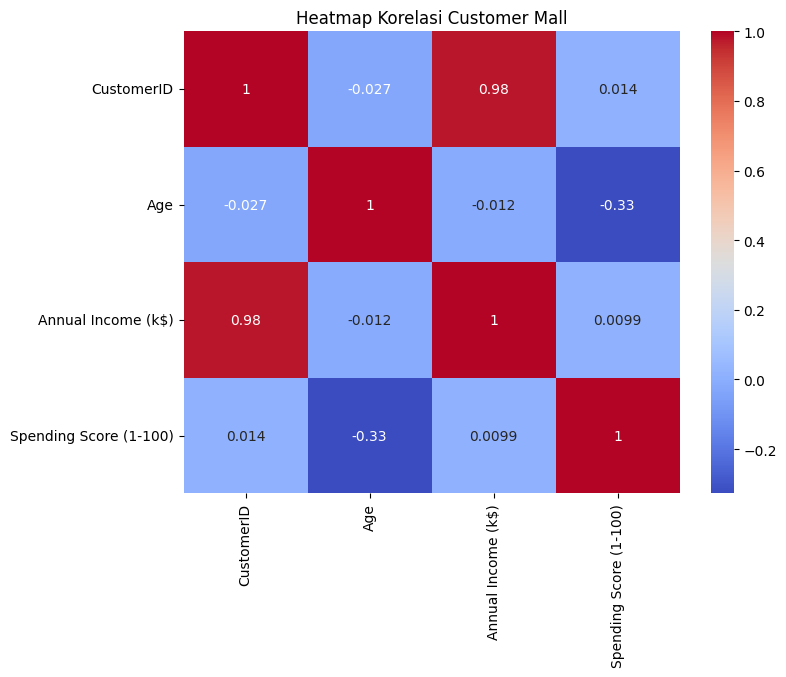

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi Customer Mall")
plt.show()

In [24]:
# uji Setiap kolom numerik
from scipy.stats import shapiro

num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
for col in num_cols:
    stat, p = shapiro(df[col])
    print(col, "=> p-value =", p)


Age => p-value = 2.710855723091019e-06
Annual Income (k$) => p-value = 0.0035365109581996213
Spending Score (1-100) => p-value = 0.00024229713933301153


In [25]:
# Pemilihan kolom numerik
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]


In [29]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

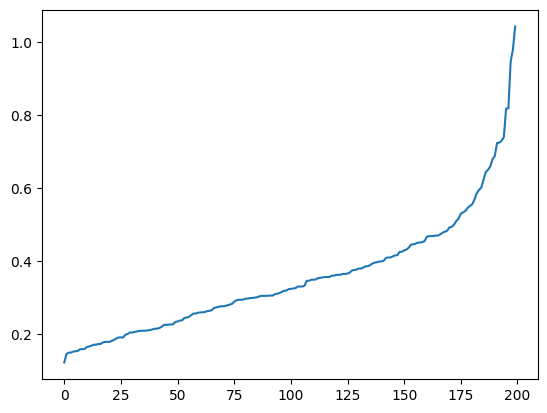

In [30]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,4])
plt.plot(distances)
plt.show()

Bikin plot jarak ke tetangga ke-k (biasanya k = min_samples − 1). Lalu cari bagian grafik yang ada ‘titik sikunya’. Nilai jarak di titik siku itu biasanya cocok buat jadi eps.

In [31]:
# menjalankan DBSCAN
db = DBSCAN(eps=0.35, min_samples=5)
labels = db.fit_predict(X_scaled)
df['Cluster'] = labels


Model DBSCAN dibuat pakai parameter yang sudah dipilih.

Labels nunjukkin tiap titik masuk cluster mana.

Label -1 berarti titik itu dianggap noise/outlier.

Hasilnya ditambah sebagai kolom Cluster di DataFrame.

Mengevaluasi Silhoutte

In [32]:
from sklearn.metrics import silhouette_score
if len(set(labels) - {-1}) > 1:
    score = silhouette_score(X_scaled[labels!=-1], labels[labels!=-1])
    print("Silhouette:", score)
else:
    print("Tidak bisa hitung Silhouette (terlalu sedikit cluster)")


Silhouette: 0.47170477610650546


Visualisasi Hasil 2D (Visual membantu menilai bentuk cluster & posisi noise.)

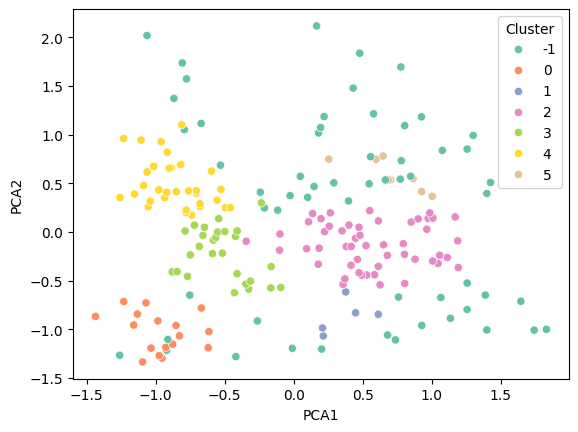

In [33]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_scaled)
df['PCA1'], df['PCA2'] = pca_res[:,0], pca_res[:,1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.show()


Visualisasi interaktif (plot interaktif untuk eksplorasi.)

In [34]:
fig = px.scatter(df, x='PCA1', y='PCA2', color=df['Cluster'].astype(str),
                 hover_data=['Age','Annual Income (k$)','Spending Score (1-100)'])
fig.show()


In [39]:
# ubah angka cluster jadi kategori deskriptif supaya interpretasi laporan lebih mudah.
# Pastikan mapping disesuaikan berdasarkan ringkasan statistik tiap cluster
df['Cluster_Label'] = df['Cluster'].map({0:'Baik', 1:'Kurang', -1:'Noise'}).fillna('Lainnya')


In [40]:
# memahami karakteristik tiap cluster (mis. cluster A = usia muda + income sedang + spending tinggi). Ini bahan utama untuk analisis kualitatif di laporan.
summary = df.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean()
summary['count'] = df.groupby('Cluster').size()
summary


,Age,Annual Income (k$),Spending Score (1-100),count
Cluster,,,,
-1,40.310345,68.396552,31.120690,58
0,23.764706,25.823529,78.176471,17
1,38.200000,27.800000,31.800000,5
2,53.288462,54.230769,48.634615,52
3,24.107143,54.321429,50.464286,28
4,32.750000,80.875000,83.625000,32
5,42.875000,79.750000,16.125000,8


In [37]:
# menyimpan model DBSCAN
df.to_csv('mall_customers_clustered.csv', index=False)

import joblib
joblib.dump(db, 'dbscan_model.joblib')


['dbscan_model.joblib']

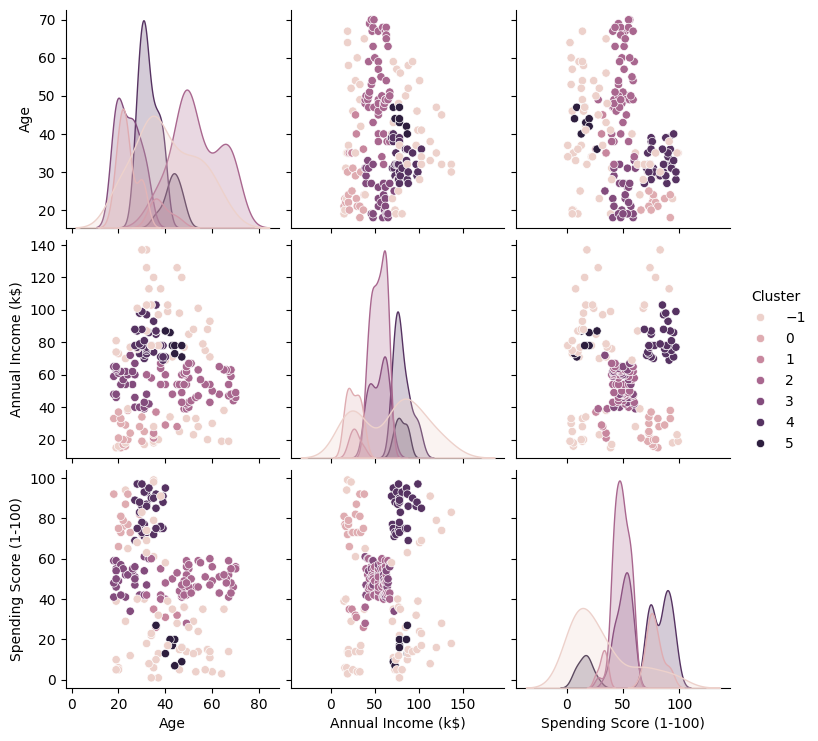

In [41]:
sns.pairplot(df[['Age','Annual Income (k$)','Spending Score (1-100)','Cluster']], hue='Cluster')


Pairplot menampilkan hubungan antar 3 fitur numerik:

Age

Annual Income (k$)

Spending Score (1–100)

Setiap titik diberi warna sesuai cluster hasil DBSCAN.